In [1]:
import torch, math
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from nets import Qnetn, MLP_NN
from taskmeta import SINTASK, SINTASK2, SINTASK3, SIN_xlow, SIN_xhigh


device, dtype = 'cpu', torch.float32
def tensor(data, rgrad=False):
    return torch.tensor(data, device=device, dtype=dtype, requires_grad=rgrad)

GRS = 12
RNG = np.random.default_rng(GRS)
randseed = lambda : RNG.integers(1, 10_000)
xl, xh = SIN_xlow, SIN_xhigh

HH = [1, 25, 25, 25, 1]
lossF = lambda pp, yy: 0.5 * (pp-yy)**2
lossM = lambda pp, yy: torch.sum(0.5 * (pp - yy) ** 2) 

NN = lambda : MLP_NN(HH, device, dtype, actF=nn.ReLU, seed=randseed())
NP = lambda ext_params: MLP_NN(ext_params, device, dtype, actF=nn.ReLU, seed=randseed(), from_param=True)

# Meta Learning

In [2]:
taskerL = [
    SINTASK2((7, 3), seed=randseed()),
    SINTASK2((6, 2), seed=randseed()),
    SINTASK2((5, 1), seed=randseed()),
    SINTASK2((4, 0), seed=randseed()),
    SINTASK2((3, -1), seed=randseed()),
] 
tasker = taskerL[0]

# algorithm

In [3]:
inner_epochs =  1000
inner_lr =      0.001
train_K =       8
P = print

In [4]:
# load theta
model = NN()
model.load_external('meta_pie') #<---- comment this to not use meta pie
model.info(show_vals=True)

--------------------------
~ N_LAYERS:[4]
~ D_TYPE:[torch.float32]
~ DEV:[cpu]
--------------------------
--> Weights[0]:: Params[25] of Shape[torch.Size([25, 1])]
 ~--> [PARAMETER TENSOR]: tensor([[ 2.4490e-03],
        [-8.0139e-02],
        [-2.5064e-01],
        [ 9.5909e-01],
        [-6.5284e-05],
        [ 4.8062e-01],
        [-8.6809e-02],
        [ 6.5355e-03],
        [ 4.4192e-01],
        [-7.2053e-01],
        [ 8.9951e-01],
        [-1.7595e-02],
        [-2.0167e-02],
        [-1.3581e-01],
        [-2.8878e-01],
        [-5.0440e-02],
        [-5.0478e-02],
        [-2.3697e-02],
        [-6.8030e-02],
        [-4.1850e-01],
        [-2.6412e-02],
        [ 5.6413e-04],
        [-8.6678e-02],
        [-4.2174e-03],
        [-2.6082e-01]], requires_grad=True)
--> Bias[0]:: Params[25] of Shape[torch.Size([25])]
 ~--> [PARAMETER TENSOR]: tensor([-1.6234e-02, -3.8518e-02,  9.0392e-01, -2.0014e+00, -2.5732e-02,
        -1.0545e+00, -9.3511e-02, -6.5731e-02, -9.8871e-01,  6.

1376

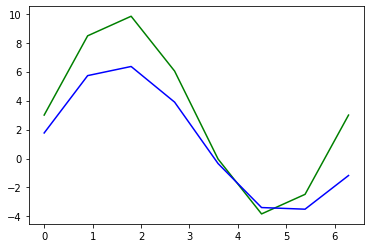

In [5]:
db =tasker.space(train_K)
bx = torch.tensor(np.expand_dims(db[ :, 0 ],axis=-1), dtype=torch.float32)
by = torch.tensor(np.expand_dims(db[ :, 1 ],axis=-1), dtype=torch.float32)
bp = []
with torch.no_grad():
    pred=model.forward(bx)
    plt.plot(db[:,0], db[:,1], color='green')
    plt.plot(db[:,0], pred, color='blue')


# training

	 Loss: 23.305706024169922
	 Loss: 11.764640808105469
	 Loss: 9.970715522766113
	 Loss: 15.562658309936523
	 Loss: 15.300835609436035
	 Loss: 3.1714959144592285
	 Loss: 1.517108678817749
	 Loss: 1.7138500213623047
	 Loss: 5.398362159729004
	 Loss: 1.9111354351043701
	 Loss: 1.9912546873092651
	 Loss: 2.843540906906128
	 Loss: 3.6294186115264893
	 Loss: 5.613681793212891
	 Loss: 2.70523738861084
	 Loss: 0.6384687423706055
	 Loss: 2.4986822605133057
	 Loss: 2.8610525131225586
	 Loss: 2.856957197189331
	 Loss: 2.222862720489502
	 Loss: 2.4383344650268555
	 Loss: 2.4408180713653564
	 Loss: 3.905010461807251
	 Loss: 0.4244096279144287
	 Loss: 0.23769883811473846
	 Loss: 4.231045246124268
	 Loss: 1.8475152254104614
	 Loss: 0.7583202123641968
	 Loss: 0.08891812711954117
	 Loss: 1.647444725036621
	 Loss: 0.44765952229499817
	 Loss: 0.4603881537914276
	 Loss: 0.9497236609458923
	 Loss: 0.5775789618492126
	 Loss: 5.595859050750732
	 Loss: 7.771947860717773
	 Loss: 0.6060735583305359
	 Loss: 0.99

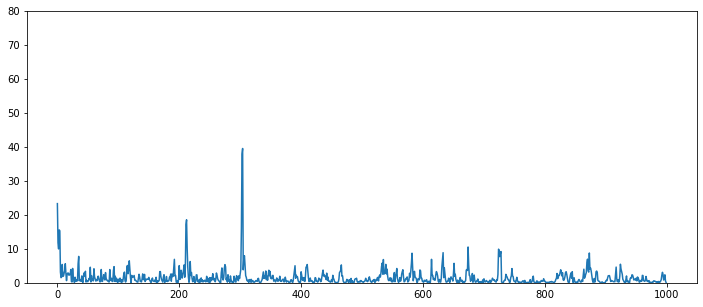

In [6]:


loss_hist=[]
for inner_epoch in range(inner_epochs):

    #P('# 5: sample train_K data points', train_K)
    train_db =tasker.sample(train_K)
    batch_x = torch.tensor(np.expand_dims(train_db[ :, 0 ],axis=-1), dtype=torch.float32)
    batch_y = torch.tensor(np.expand_dims(train_db[ :, 1 ],axis=-1), dtype=torch.float32)

    #P('# 6: evaluate grad_theta(loss)')
    model.zero_grad()
    pred = model.forward(batch_x)
    loss =  lossM(pred, batch_y) #torch.sum((pred - batch_y) ** 2) 
    
    loss_hist.append(loss.item())
    P('\t Loss:', loss_hist[-1])
    #loss.backward(create_graph=True)
    grads = torch.autograd.grad(loss, model.parameters, create_graph=False)

    #P('# 7: compute adapted paramters with grad descent')
    with torch.no_grad():
        for t_param, grad in zip(model.parameters, grads):
            t_param -= inner_lr * grad

plt.figure(figsize=(12,5))
plt.ylim(0,80)
plt.plot(loss_hist)
plt.show()

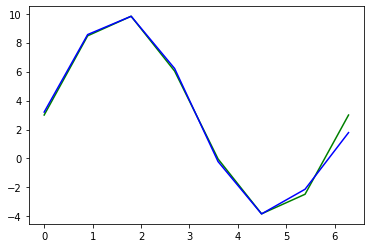

In [7]:
db =tasker.space(train_K)
bx = torch.tensor(np.expand_dims(db[ :, 0 ],axis=-1), dtype=torch.float32)
by = torch.tensor(np.expand_dims(db[ :, 1 ],axis=-1), dtype=torch.float32)
bp = []
with torch.no_grad():
    pred=model.forward(bx)
    plt.plot(db[:,0], db[:,1], color='green')
    plt.plot(db[:,0], pred, color='blue')
